#  Projet SOC IA : Système Intelligent de Triage d'Alertes
### Analyse Exploratoire des Données (EDA) & Validation du Dataset

---

## 1. Contexte du Projet
Dans un centre d'opérations de sécurité (SOC) moderne, les analystes souffrent de **"l'Alert Fatigue"** causée par un volume excessif de logs et de faux positifs.
Ce projet vise à développer une **IA** capable d'analyser les flux réseaux pour :
1.  **Filtrer** le trafic normal (Bruit).
2.  **Classifier** précisément le type d'attaque.

## 2. La Mission de l'IA (Périmètre Fonctionnel)
Le modèle de Machine Learning est entraîné pour détecter et nommer **3 familles de cybermenaces** (Classification Multi-Classes) :

| Famille | Types d'Attaques Couverts | Journée Source |
| :--- | :--- | :--- |
|  **Web (Applicatif)** | SQL Injection, XSS, Brute Force Web | *Jeudi* |
| **Accès (Auth)** | Brute Force SSH, Brute Force FTP | *Mardi* |
|**Réseau (Volumétrie)** | DDoS, DoS (Hulk, Slowloris), Botnets, PortScan | *Mercredi / Vendredi* |


> **Objectif Technique :**Afin de garantir une prise de décision instantanée et sans ambiguïté pour les analystes SOC, le système est conçu comme un filtre binaire strict :

Fonctionnement : L'IA analyse les logs  et rend un verdict unique : "ATTAQUE  (1)" ou "NORMAL (0)".

---

## 3. Le Dataset : CIC-IDS2017 (Fusionné)
Nous utilisons le dataset de référence **CIC-IDS2017** (Canadian Institute for Cybersecurity).
* **Nature :** Trafic réseau réel simulant un environnement d'entreprise complet (Firewall, Serveurs, Utilisateurs).
* **Traitement :** Fusion des fichiers CSV de la semaine (Mardi à Vendredi) pour obtenir une vue à 360°.
* **Features :** ~79 colonnes basées sur les flux (Flow Duration, Packet Size, Inter-Arrival Time, etc.).
---

## 4. Objectifs de ce Notebook
Ce notebook d'exploration a pour but de valider la qualité des données avant l'entraînement  :
* Vérifier l'équilibre des classes (Normal vs Attaques).
*  Identifier et nettoyer les valeurs invalides (`NaN`, `Infinity`).
*  Visualiser les corrélations (Quels ports sont attaqués ?).
*  Sélectionner les Features pertinentes.

---
**Auteur : AIT ATMANE Samir | **Stack :** Python, Pandas, Seaborn

1- Importations des bibliothéques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
data_1 = pd.read_csv("./data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
data_2 = pd.read_csv("./data/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
data_3 = pd.read_csv("./data/Friday-WorkingHours-Morning.pcap_ISCX.csv")
data_4 = pd.read_csv("./data/Monday-WorkingHours.pcap_ISCX.csv")
data_5 = pd.read_csv("./data/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
data_6 = pd.read_csv("./data/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
data_7 = pd.read_csv("./data/Tuesday-WorkingHours.pcap_ISCX.csv")
data_8 = pd.read_csv("./data/Wednesday-workingHours.pcap_ISCX.csv")




In [3]:
data_list = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8]

print('Les dimension des data : ')
for i, data in enumerate(data_list, start = 1):
  rows, cols = data.shape
  print(f'Data{i} -> {rows} rows, {cols} columns')

Les dimension des data : 
Data1 -> 225745 rows, 79 columns
Data2 -> 286467 rows, 79 columns
Data3 -> 191033 rows, 79 columns
Data4 -> 529918 rows, 79 columns
Data5 -> 288602 rows, 79 columns
Data6 -> 170366 rows, 79 columns
Data7 -> 445909 rows, 79 columns
Data8 -> 692703 rows, 79 columns


In [4]:
data = pd.concat(data_list)
rows, cols = data.shape

print('New dimension:')
print(f'Number of rows: {rows}')
print(f'Number of columns: {cols}')
print(f'Total cells: {rows * cols}')

New dimension:
Number of rows: 2830743
Number of columns: 79
Total cells: 223628697


In [5]:
# Renaming the columns by removing leading/trailing whitespace
col_names = {col: col.strip() for col in data.columns}
data.rename(columns = col_names, inplace = True)

In [6]:
data.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [8]:
def optimize_memory(df):
    # Convertir les nombres à virgule (float64 -> float32)
    floats = df.select_dtypes(include=['float64']).columns
    df[floats] = df[floats].astype('float32')
    
    # Convertir les entiers (int64 -> int32)
    ints = df.select_dtypes(include=['int64']).columns
    df[ints] = df[ints].astype('int32')
    
    return df

# Appliquez l'optimisation
data = optimize_memory(data)

# Réessayez maintenant
data.describe().transpose()

C:\Users\serka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\serka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,std,min,25%,50%,75%,max
Destination Port,2830743.0,8.071483e+03,1.828363e+04,0.0,53.0,80.0,443.0,65535.0
Flow Duration,2830743.0,1.478566e+07,3.365374e+07,-13.0,155.0,31316.0,3204828.5,119999998.0
Total Fwd Packets,2830743.0,9.361160e+00,7.496728e+02,1.0,2.0,2.0,5.0,219759.0
Total Backward Packets,2830743.0,1.039377e+01,9.973883e+02,0.0,1.0,2.0,4.0,291922.0
Total Length of Fwd Packets,2830743.0,5.493024e+02,9.993589e+03,0.0,12.0,62.0,187.0,12900000.0
...,...,...,...,...,...,...,...,...
Active Min,2830743.0,5.829582e+04,5.770923e+05,0.0,0.0,0.0,0.0,110000000.0
Idle Mean,2830743.0,8.316038e+06,2.363008e+07,0.0,0.0,0.0,0.0,120000000.0
Idle Std,2830743.0,5.038439e+05,4.602984e+06,0.0,0.0,0.0,0.0,76900000.0
Idle Max,2830743.0,8.695752e+06,2.436689e+07,0.0,0.0,0.0,0.0,120000000.0


2.2 Nettoyage de données 


Les doubloun


In [9]:
data.drop_duplicates(inplace = True)
data.shape

(2499748, 79)

Les valeurs manquent

In [10]:
missing_val = data.isna().sum()
print(missing_val.loc[missing_val > 0])

Flow Bytes/s    353
dtype: int64


In [11]:

# Checking for infinity values
numeric_cols = data.select_dtypes(include = np.number).columns
inf_count = np.isinf(data[numeric_cols]).sum()
print(inf_count[inf_count > 0])
     

Flow Bytes/s      1210
Flow Packets/s    1563
dtype: int64


In [12]:
# Replacing any infinite values (positive or negative) with NaN (not a number)
print(f'Initial missing values: {data.isna().sum().sum()}')

data.replace([np.inf, -np.inf], np.nan, inplace = True)

print(f'Missing values after processing infinite values: {data.isna().sum().sum()}')

Initial missing values: 353
Missing values after processing infinite values: 3126


In [13]:
before = data.shape[0]
data.dropna(inplace=True)
after = data.shape[0]

print(f" Lignes supprimées (NaN) : {before - after}")
print(f" Dataset final : {after} lignes")


 Lignes supprimées (NaN) : 1563
 Dataset final : 2498185 lignes


Objectif des visuels : 

Les graphiques doivent répondre à 3 questions clés :

1 "Est-ce que mes données sont équilibrées ?" (Bar Plot)
Le Graphe : Bar Plot
L'analyse : Ce graphique montre la répartition entre le trafic "BENIGN" (Normal) et les différentes attaques.


2 "Peut-on distinguer les attaques du trafic normal ?" (Scatter Plot)
Le Graphe : scatter
L'analyse : Ce nuage de points croise le Temps (combien de temps dure la connexion) et la Taille (la grosseur moyenne des paquets).


3 "Y a-t-il des anomalies flagrantes (Outliers) ?" (Boxplot)
Le Graphe : boxplot

L'analyse : Il montre la distribution du débit (paquets par seconde).

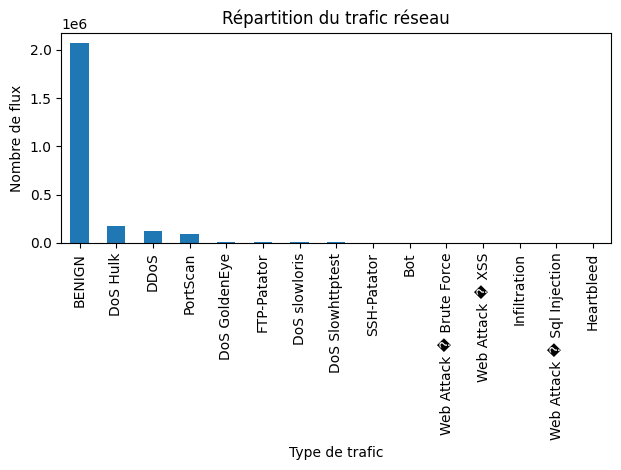

In [14]:

label_counts = data["Label"].value_counts()

plt.figure()
label_counts.plot(kind="bar")
plt.title("Répartition du trafic réseau")
plt.xlabel("Type de trafic")
plt.ylabel("Nombre de flux")
plt.tight_layout()
plt.show()

la distribution du trafic réseau reste fortement déséquilibrée, avec une 
majorité écrasante de flux bénins (*BENIGN*) et une présence minoritaire mais cohérente des 
différentes familles d’attaques. Cette stabilité confirme que les opérations de nettoyage 
ont amélioré la qualité des données sans altérer leur structure statistique.

Ce déséquilibre est représentatif d’un environnement SOC réel, où les événements malveillants 
sont rares comparés au volume de trafic légitime. Il justifie pleinement l’utilisation de 
métriques adaptées (Recall, F1-score) et d’une architecture de détection en cascade pour la 
suite du projet.

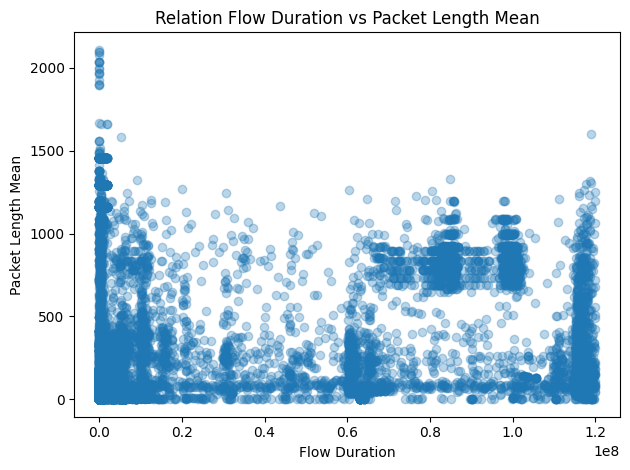

In [15]:
sample = data.sample(30000, random_state=42)

plt.figure()
plt.scatter(
    sample["Flow Duration"],
    sample["Packet Length Mean"],
    alpha=0.3
)

plt.title("Relation Flow Duration vs Packet Length Mean")
plt.xlabel("Flow Duration")
plt.ylabel("Packet Length Mean")
plt.tight_layout()
plt.show()


La dispersion observée montre des zones de comportement distinctes, confirmant que la combinaison des features réseau permet de séparer trafic normal et malveillant.


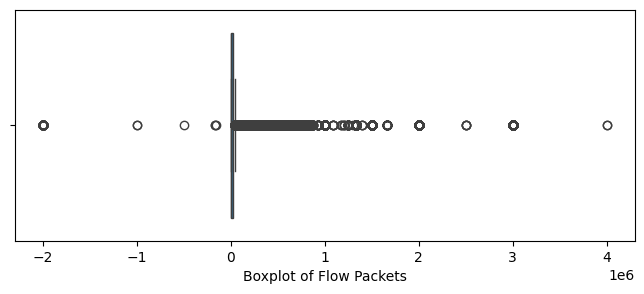

In [16]:
plt.figure(figsize = (8, 3))
sns.boxplot(x = data['Flow Packets/s'])
plt.xlabel('Boxplot of Flow Packets')
plt.show()

In [17]:
import gc # Garbage Collector pour libérer la mémoire

# 1. Identifier seulement les index des lignes à supprimer (très léger en mémoire)
index_a_supprimer = data[data['Flow Packets/s'] < 0].index

# 2. Supprimer ces lignes directement dans l'objet existant
data.drop(index_a_supprimer, inplace=True)

# 3. Forcer le nettoyage de la mémoire vive
gc.collect()

print("Nettoyage des valeurs négatives terminé.")

Nettoyage des valeurs négatives terminé.


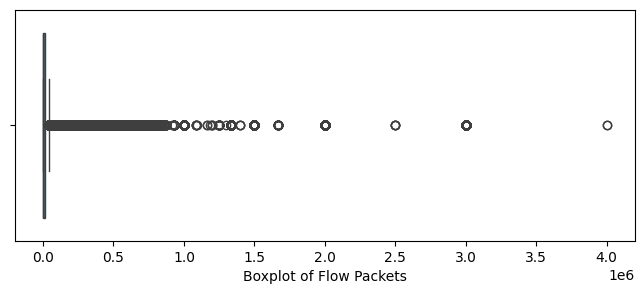

In [18]:
plt.figure(figsize = (8, 3))
sns.boxplot(x = data['Flow Packets/s'])
plt.xlabel('Boxplot of Flow Packets')
plt.show()

Ce graphe sert à prouver visuellement qu'il y a des valeurs extrêmes dans votre dataset qui ne ressemblent pas au trafic normal. C'est souvent la signature d'une attaque.


On a corrigé les données et supprimé les flux négatifs, car ce n’est pas physiquement possible.

Échantillon prêt pour la visualisation.


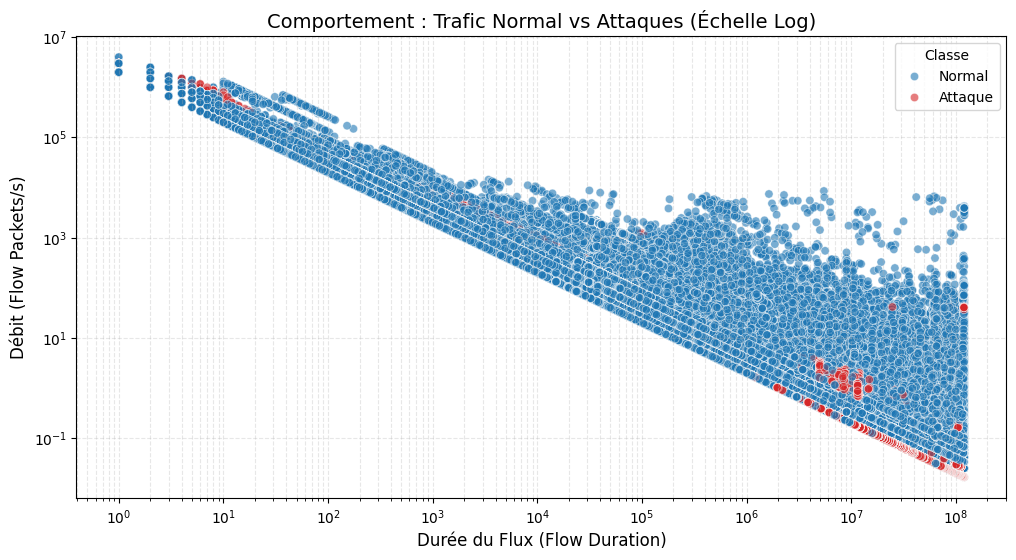

In [19]:
data['Type'] = data['Label'].apply(lambda x: 'Normal' if x == 'BENIGN' else 'Attaque')

print("Échantillon prêt pour la visualisation.")

plt.figure(figsize=(12, 6))

# On utilise une échelle Logarithmique (log) car les écarts sont géants
sns.scatterplot(data=data, 
                x='Flow Duration', 
                y='Flow Packets/s', 
                hue='Type',          # La couleur change selon Normal/Attaque
                palette={'Normal': 'tab:blue', 'Attaque': 'tab:red'},
                alpha=0.6)           # Transparence pour voir les points superposés

# Réglage des échelles en Log pour mieux voir
plt.xscale('log')
plt.yscale('log')

plt.title('Comportement : Trafic Normal vs Attaques (Échelle Log)', fontsize=14)
plt.xlabel('Durée du Flux (Flow Duration)', fontsize=12)
plt.ylabel('Débit (Flow Packets/s)', fontsize=12)
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.legend(title='Classe')

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import gc
# Pour gérer la mémoire
# 1. Configuration de la découpe
# test_size=0.15  -> 15% pour le test
# random_state=42 -> Pour que ce soit TOUJOURS la même découpe (Reproductibilité)
# stratify=data['Label'] -> Pour garder le même équilibre (DDoS, Normal...) dans les 15%

print("Début de la découpe des données...")

train_set, test_set = train_test_split(
    data, 
    test_size=0.15, 
    stratify=data['Label'], 
    random_state=42
)

print(f"Taille Entraînement : {train_set.shape}")
print(f"Taille Test (Golden Set) : {test_set.shape}")

# 2. Vérification de l'équilibre (Optionnel mais recommandé)
print("\nDistribution dans le TEST set (en %) :")
print(test_set['Label'].value_counts(normalize=True) * 100)

# 3. Sauvegarde en CSV (C'est là que tu figes tes données pour toujours)
# On utilise index=False pour ne pas créer une colonne d'index inutile
print("\nSauvegarde des fichiers en cours... (Cela peut prendre un peu de temps)")

train_set.to_csv('train_set_final.csv', index=False)
test_set.to_csv('test_set_final.csv', index=False)

print("✅ Terminé ! Fichiers 'train_set_final.csv' et 'test_set_final.csv' créés.")

# 4. Libération de la mémoire (Important vu tes erreurs précédentes)
del data
gc.collect()

Début de la découpe des données...
Taille Entraînement : (2122937, 80)
Taille Test (Golden Set) : (374636, 80)

Distribution dans le TEST set (en %) :
Label
BENIGN                        82.958392
DoS Hulk                       6.918716
DDoS                           5.123640
PortScan                       3.630724
DoS GoldenEye                  0.411866
FTP-Patator                    0.237564
DoS slowloris                  0.215409
DoS Slowhttptest               0.209270
SSH-Patator                    0.128925
Bot                            0.077942
Web Attack � Brute Force       0.058724
Web Attack � XSS               0.026159
Infiltration                   0.001335
Web Attack � Sql Injection     0.000801
Heartbleed                     0.000534
Name: proportion, dtype: float64

Sauvegarde des fichiers en cours... (Cela peut prendre un peu de temps)
✅ Terminé ! Fichiers 'train_set_final.csv' et 'test_set_final.csv' créés.


7580